# COVID mortality rates per country

This is a naive analysis of the published  mortality rates for the COVID 19 pandemic.

- pull the data from a csv on github
- turn it into a Pandas DataFrame
- do some filtering and a couple of plots

I believe that **everyone** should be able to do this.
Doing basic data analysis should be  like  what reading and writing
was at the beginning of the 20th century - a basic skill 
taught to every child at school.

The data is published [here](https://github.com/CSSEGISandData/COVID-19)

**2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE**

This is the data repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). 

---

The age distribution for countries 
comes from [here](http://wdi.worldbank.org/table/2.1#)




https://epistat.wiv-isp.be/covid/

In [1]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Begin by reading the population data 

In [2]:
pwd

'/home/gregmcshane/COVID_stats'

In [2]:
pop_df = pd.read_csv('pop_dyn.csv',skiprows=4)
pop_df.iloc[:10,[0,-3]]

,Country Name,2018
0,Aruba,13.550947
1,Afghanistan,2.584927
2,Angola,2.216374
3,Albania,13.744736
4,Andorra,NaN
5,Arab World,4.557876
6,United Arab Emirates,1.085001
7,Argentina,11.117789
8,Armenia,11.253818
9,American Samoa,NaN


# Get the latest time series and save to disk

I got the url from the network tab in the inspection window for Chrome.
There are a  lot of tutorials on how to do [this](https://developers.google.com/web/tools/chrome-devtools/network). 
It's really one of the basic tricks of scraping now.

I download to disc using **requests** but you could do use **curl** or **wget** just as well.


In [3]:
root_dir = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
fn = 'time_series_covid19_%s_global.csv'

for ss in ['deaths','confirmed']:
    r = requests.get(root_dir + fn%ss, allow_redirects=True)
    open('covid_%s.csv'%ss, 'wb').write(r.content)


# Parse them to a DataFrames

This used to be something I'd either 
- do by hand using **String.split**
- do with **csv.reader** 

but **pd.read_csv** is very convenient.


In [4]:
df = pd.read_csv('covid_deaths.csv')
dfc = pd.read_csv('covid_confirmed.csv')

In [5]:
dfc.columns[-3:]

Index(['7/14/20', '7/15/20', '7/16/20'], dtype='object')

In [7]:
np.diff(df.iloc[116,-10:-1].values), dfc.iloc[116,-10:].values

(array([52, 57, 31, 28, 107, 81, 43, 46], dtype=object),
 array([183309, 183816, 185616, 185851, 185952, 184980, 188836, 185986,
        186538, 187067], dtype=object))

In [153]:
df.iloc[223,-10:].values

array([35341, 35704, 36042, 36393, 36675, 36793, 36914, 37048, 37460,
       37837], dtype=object)

### make a mapping from country to row index

In [6]:
c2i = { x.lower() : i for i,x in enumerate(df.iloc[:,1]) }
#have to reset these by hand :(
c2i['france'] = 116
c2i['united kingdom'] = 223
c2i['afghanistan']

0

In [7]:
df.iloc[:3,1]

0    Afghanistan
1        Albania
2        Algeria
Name: Country/Region, dtype: object

# Foyers

These are the hotspots for the pandemic
- I chose 1000 because but 300 used to be the default

In [8]:
latest = -2 if 'pop' in df.columns else -1
foyers = df[df[df.columns[latest]] > 1000]
foyers.sort_values(by=foyers.columns[latest], 
                   ascending=False).iloc[:10,[1,latest]]

,Country/Region,7/16/20
225,US,138358
28,Brazil,76688
223,United Kingdom,45119
158,Mexico,37574
137,Italy,35017
116,France,30035
201,Spain,28416
131,India,25602
133,Iran,13608
181,Peru,12615


In [10]:
foyers.iloc[:,1].values

array(['Argentina', 'Bangladesh', 'Belgium', 'Bolivia', 'Brazil',
       'Canada', 'Canada', 'Chile', 'China', 'Colombia', 'Ecuador',
       'Egypt', 'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Ireland', 'Italy', 'Mexico', 'Netherlands', 'Pakistan', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Romania', 'Russia',
       'Saudi Arabia', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
       'Turkey', 'Ukraine', 'United Kingdom', 'US'], dtype=object)

## add the population data (for 2016)
https://datahub.io/JohnSnowLabs/population-figures-by-country

this is a pain as the 'pop' column is added with index -1
so I have to change all the code from iloc[4:] to iloc[4:-1]
to avoid this number polluting the daily numbers from WHO.


In [15]:
pop = pd.read_csv('population.csv')
pop.iloc[248,0] = 'US'
pop.iloc[65,0] = 'Egypt'
pop.iloc[109,0] = 'Iran'
pop.iloc[200,0] = 'Russia'

pops = dict(list(pop.iloc[:,[0,-1] ].values))
ppp = {x: pops[x] for x in foyers.iloc[:,1].values}
df.loc[foyers.index,'pop'] =  [pops[x] for x in foyers.iloc[:,1]]
dfc.loc[foyers.index,'pop'] =  [pops[x] for x in foyers.iloc[:,1]]
df.iloc[206,-5:]

7/13/20          1968
7/14/20          1968
7/15/20          1968
7/16/20          1969
pop        8.3721e+06
Name: 206, dtype: object

In [10]:
foyers.iloc[:5,[1,-2,-1]]

,Country/Region,7/15/20,7/16/20
0,Afghanistan,1094,1113
2,Algeria,1040,1052
6,Argentina,2050,2112
20,Bangladesh,2457,2496
23,Belgium,9788,9795


In [11]:
sum([df.iloc[k,-2] for k in [116,223,137,223,169,23]])

171222

In [14]:
foyers = df[df[df.columns[-2]] > 3000]
foyers['pop'].values[:3]

array([1.13481590e+07, 2.07652865e+08, 3.62864250e+07])

Text(0,0.5,'log(deaths)')

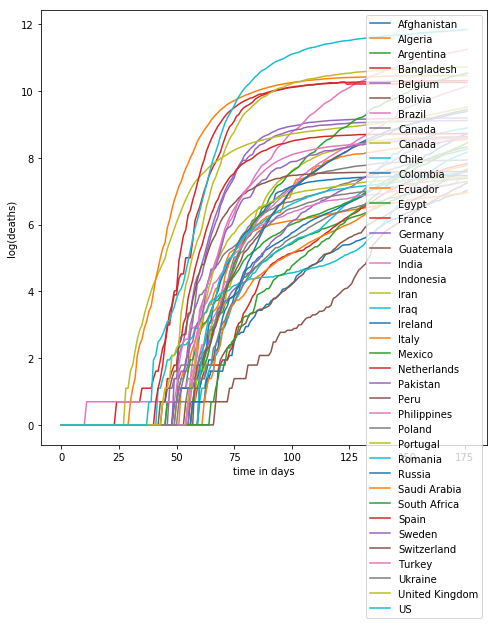

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)

for x in foyers.index:
    if df.iloc[x]["Country/Region"] in ['China']: continue
    Y = np.log( df.iloc[x].values[4:-1].astype(np.float) + 1)
    ax.plot(np.arange(len(Y)),Y, label=df.iloc[x]["Country/Region"])

#ax.axis('equal')
leg = ax.legend()
plt.xlabel('time in days')
plt.ylabel('log(deaths)')

So the graph shows log(deaths)
I don't think this is particularly useful
but you do see 

- the staggered starts
- how things are approximately linear to start with



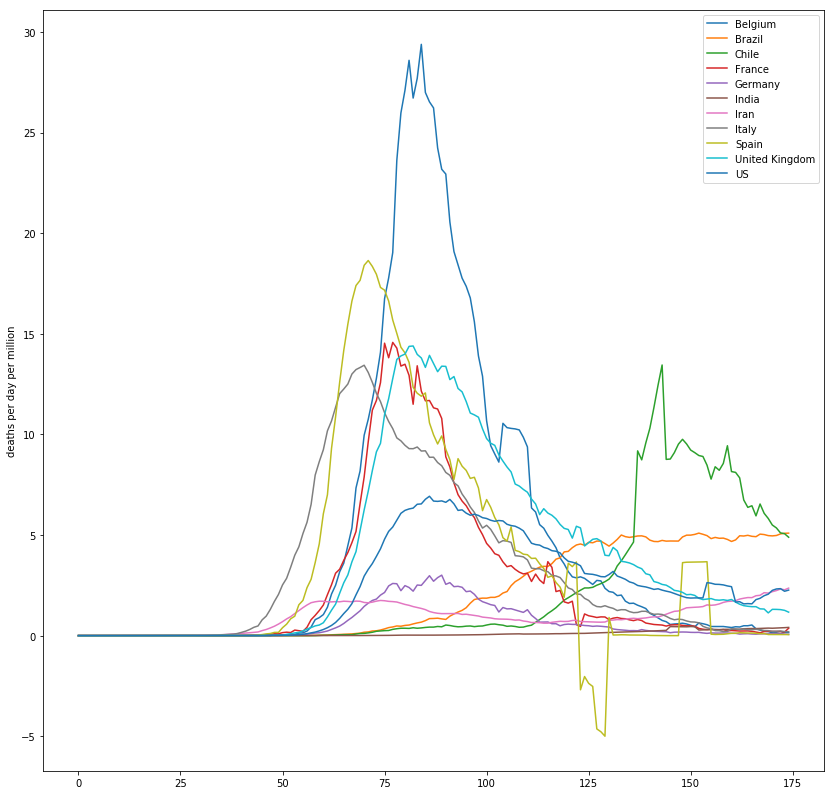

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(14,14)

for row in df.iterrows():
    row = row[1]
    name, population = row[1], row[-1]
    if row[-2] < 7000: continue
    if name.lower() in [ 'peru', 'mexico', 'russia']: continue
    x = row[4:-1].values
    
    #x[1:] - x[:-1]
    ax.plot(10**6* np.convolve(np.diff(x), np.ones(7))[:-7]/7 / population, label=name)
    
leg = ax.legend()
plt.ylabel('deaths per day per million')
plt.savefig('dd.png')

# Variations of the figures over a week

This is for the UK  but there are similar variations 
for other countries in particular the US. 

Apparently less people die at the weekend 


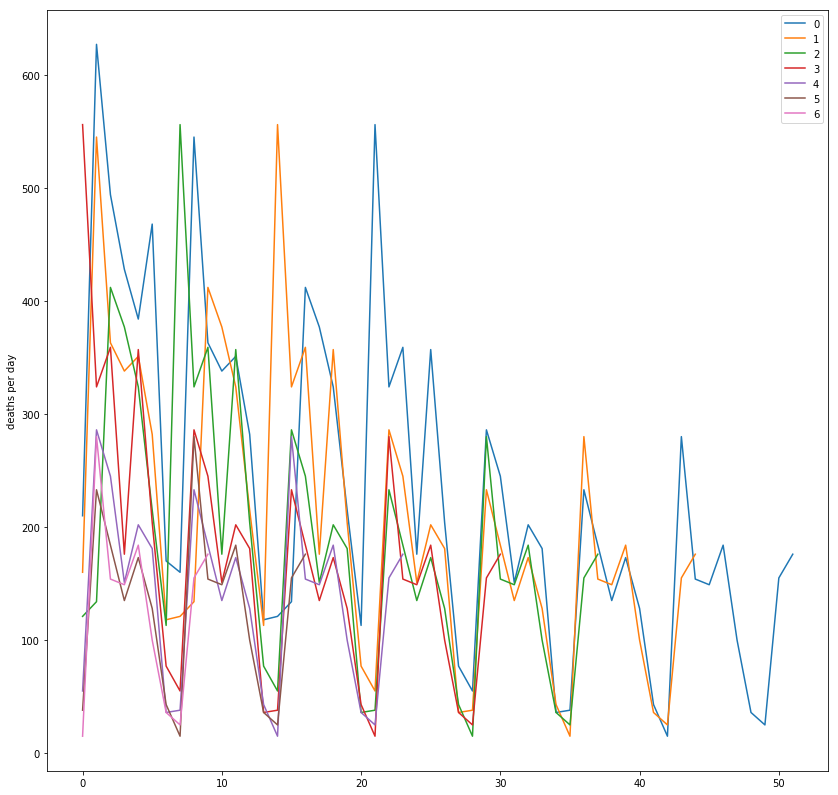

In [17]:
#-2 because -1 is population
fig, ax = plt.subplots()
fig.set_size_inches(14,14)
for k in range(7):
    Y = np.diff(df.iloc[223,-55 + k*7:-2])
    ax.plot(Y,label=str(k))
    
leg = ax.legend()
plt.ylabel('deaths per day')
plt.savefig('dd.png')

# so let's do a rolling average...

the graph shows deaths per million inhabitants.

You can see clearly that Sweden is doing something different from other countries.

The curve for the US is different too, the decline is much slower.

Germany and Portugal have similar curves, though latterly Portugal has been picking up.



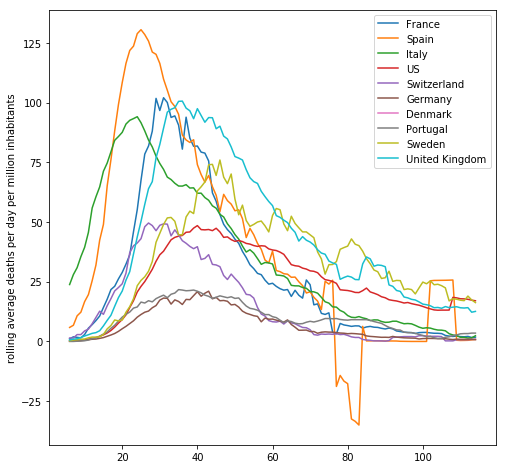

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for k in ['france',
          #'belgium',
          'spain', 
          'italy',
           'us',
          'switzerland',
          'germany','denmark', 'portugal',
          'sweden','united kingdom']:
    k = c2i[k]
    x = df.iloc[k,50:-2].rolling(7).sum()
    Y = 10**6*np.diff(x,n=1)/df.iloc[k,-1]
    #X = [(k + 6) % 7 for k in range(len(Y))]
    ax.plot(Y,label=df.iloc[k]["Country/Region"])

plt.ylabel('rolling average deaths per day per million inhabitants')
leg = ax.legend()

## per day deaths

In [19]:
day_by_day = np.diff(df.iloc[:,4:-1], axis=1)
for k in [116,120,201,137,223,225,c2i['ireland'] ]:
    print(df.iloc[k,1].ljust(15), 
          str(df.iloc[k,-2]).ljust(8),
          day_by_day[k,-7:] )

France          29794    [25 -1  0 32 27 17 14]
Germany         9006     [25  3  0  8 14  5 11]
Spain           28368    [8 3 2 3 9 9 4]
Italy           34818    [30  8 22  6 23 21 30]
United Kingdom  43995    [184 100  36  25 155 176  89]
US              128740   [605 489 240 351 721 673 635]
Ireland         1738     [3 4 1 0 1 2 0]


# So let's make a league table

most deaths per million. 
- The winner is **Belgium**.
- **France** cheated by reporting all the retirment home deaths at once
- my numbers for Russian must be wrong


In [20]:
tt = sorted([( max(np.diff(df.iloc[k][4:-1])), k) 
                for k in foyers.index], 
                    key=lambda x: -x[0]/ppp[df.iloc[x[1],1]])
for x,y in tt:
    cn = df.iloc[y,1]
    print(cn.ljust(15),  str(x).ljust(5), '%.2f'%(x/ppp[cn]*ppp['France']) )

Belgium         496   2923.86
Chile           627   2341.96
Spain           1179  1698.19
Ecuador         410   1673.93
France          1436  1436.00
Russia          232   1302.28
Sweden          185   1249.68
United Kingdom  1172  1194.48
Italy           919   1014.47
Netherlands     234   919.81
Peru            380   800.05
Mexico          1092  572.76
US              2614  541.17
Brazil          1473  474.53
Colombia        310   426.24
Germany         510   412.70
Canada          202   372.40
Iran            162   135.00
Turkey          127   106.85
India           2003  101.19
Egypt           97    67.81
China           1290  62.59
Pakistan        178   61.63


# Linear regression

If a quantity is growing/decaying exponentially 
then by taking logs we should get a straight line....

We can calculate the best fit straight line 
to the data by doing linear regression.



In [21]:
from scipy import stats


def lin_reg(mdf, indices, 
            window_end=-2,
            window=10):
    
    X = []
    for c in indices:
        Y = mdf.iloc[c].values[ -window + window_end: window_end].astype(np.float)
        # apply a cut off
        Y = np.log(Y[Y > 100])
        #print(c, Y)
        vv = stats.linregress(np.arange(len(Y)), Y)
        X.append((c, np.exp(vv.slope), np.exp(vv.intercept).astype(int) ))
    return X

## these are the results

In [22]:
ww = 6 
we = -2
cc = countries = [x for x in foyers.index if x != 62]

X = list(zip(* lin_reg(df,cc,
                       window=ww,
                       window_end=we,)))

Z = list(zip(* lin_reg(dfc,cc,
                        window=ww,
                       window_end=we,)))

# I should really start a fresh array but I'm lazy

X[2] = Z[1]
X[0] = [dfc.iloc[x]["Country/Region"] for x in X[0]]
dff = pd.DataFrame({'country' : X[0], 'deaths': X[1], 'confirmed': X[2]})
dff

,country,deaths,confirmed
0,Belgium,1.000469,1.001378
1,Brazil,1.015624,1.025956
2,Canada,1.003116,1.001463
3,Chile,1.024034,1.015373
4,Colombia,1.044754,1.044271
5,Ecuador,1.007879,1.011799
6,Egypt,1.029651,1.021959
7,France,1.000561,1.001980
8,Germany,1.000713,1.001984
9,India,1.026076,1.036222


# Calculate days till herd immunity achieved

- The population is roughly $67 \times 10^6$.
- dfc holds the stats for confirmed cases
- dff holds the growth rates

So we need to do something like
$$\frac{1}{ \text{growth rate}} \times
\log \left( .6 \times \frac{\text{Population}}{\text{# infected total}} 
\right)
$$

When I think about it whether it's .6 or .4 makes hardly any difference
because we are taking logs and the difference is less than 1/2.

In [21]:
k = 8
np.log( dff.iloc[k,2])   + np.log( dff.iloc[k,1]) ,  dfc.iloc[116, -1]

(0.0033062059988091383, 187067)

In [95]:
dfc.iloc[116, -1]/df.iloc[116,-1]*85

0.1880134014969391

In [53]:
np.log(.6*67*10**6/ 10/ dfc.iloc[116, -1]) /np.log(1.05),  dfc.iloc[116, -1]

(67.95846307322266, 145960)

# Let's see how the countries are grouped

Text(0,0.5,'confirmed cases growth rate')

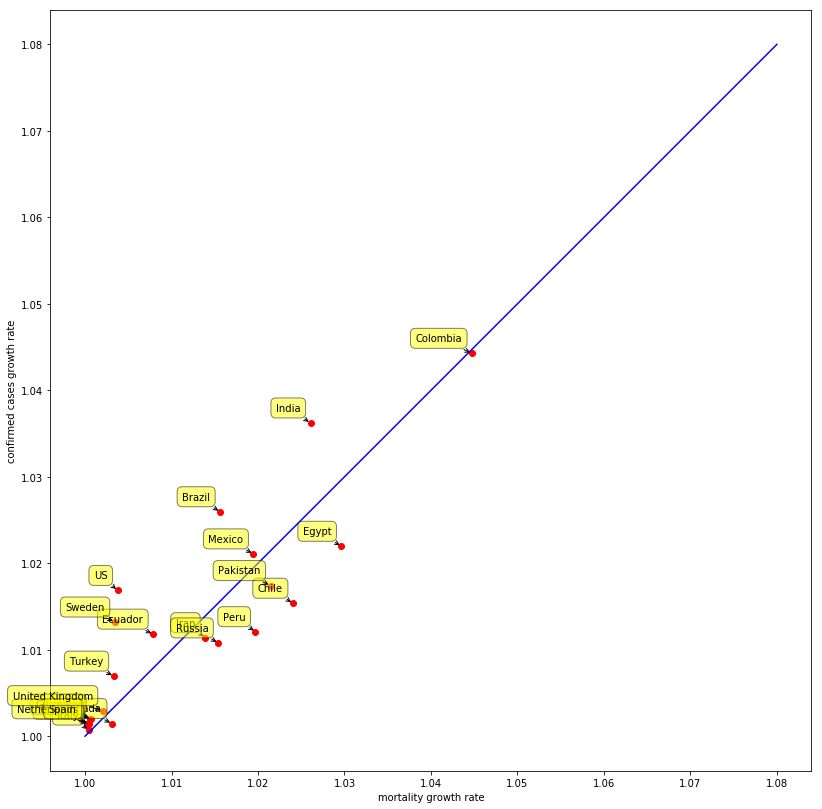

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(14,14)
for label, x, y in zip(dff['country'], dff['deaths'], dff['confirmed']):
    #if x > 1.03 : continue
    ax.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax.plot(dff['deaths'],dff['confirmed'],'ro')
ax.set_aspect('equal')

bx = [min(dff['confirmed']),max(dff['deaths'])]
bx = [1, 1.08]
plt.plot(bx,bx,'b')
plt.xlabel('mortality growth rate')
plt.ylabel('confirmed cases growth rate')